<a href="https://colab.research.google.com/github/BigTMiami/colabtest/blob/main/Colab_Machine_Translation_LSTM_TUNING.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


*Machine Translation Jupyter Notebook.  (c) 2021 Georgia Tech*

*Copyright 2021, Georgia Institute of Technology (Georgia Tech) <br>Atlanta, Georgia 30332<br>All Rights Reserved*

*Georgia Tech asserts copyright ownership of this template and all derivative works, including solutions to the projects assigned in this course. Students and other users of this template code are advised not to share it with others or to make it available on publicly viewable websites including repositories such as Github, Bitbucket, and Gitlab.  This copyright statement should not be removed or edited.*

*Sharing solutions with current or future students of CS 7643 Deep Learning is prohibited and subject to being investigated as a GT honor code violation.*

*DO NOT EDIT ANYTHING ABOVE THIS LINE*

# Machine Translation with Seq2Seq and Transformers
In this exercise you will implement a [Sequence to Sequence(Seq2Seq)](https://arxiv.org/abs/1703.03906) and a [Transformer](https://arxiv.org/pdf/1706.03762.pdf) model and use them to perform machine translation.

**A quick note: if you receive the following TypeError "super(type, obj): obj must be an instance or subtype of type", try re-importing that part or restarting your kernel and re-running all cells.** Once you have finished making changes to the model constuctor, you can avoid this issue by commenting out all of the model instantiations after the first (e.g. lines starting with "model = TransformerTranslator(*args, **kwargs)").

# ** 1: Introduction**

## Multi30K: Multilingual English-German Image Descriptions

[Multi30K](https://github.com/multi30k/dataset) is a dataset for machine translation tasks. It is a multilingual corpus containing English sentences and their German translation. In total it contains 31014 sentences(29000 for training, 1014 for validation, and 1000 for testing).
As one example:

En: `Two young, White males are outside near many bushes.`

De: `Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.`

You can read more info about the dataset [here](https://arxiv.org/abs/1605.00459). The following parts of this assignment will be based on this dataset.

## TorchText: A PyTorch Toolkit for Text Dataset and NLP Tasks
[TorchText](https://github.com/pytorch/text) is a PyTorch package that consists of data processing utilities and popular datasets for natural language. They serve to help with data splitting and loading, token encoding, sequence padding, etc. You don't need to know about how TorchText works in detail, but you might want to know about why those classes are needed and what operations are necessary for machine translation. This knowledge can be migrated to all sequential data modeling. In the following parts, we will provide you with some code to help you understand.

 You can refer to torchtext's documentation(v0.9.0) [here](https://pytorch.org/text/).

## Spacy
Spacy is package designed for tokenization in many languages. Tokenization is a process of splitting raw text data into lists of tokens that can be further processed. Since TorchText only provides tokenizer for English, we will be using Spacy for our assignment.


**Notice: For the following assignment, we strongly recommend you to work in a virtual python environment. We recommend Anaconda, a powerful environment control tool. You can download it [here](https://www.anaconda.com/products/individual)**.

## ** 1.1: Prerequisites**
Before you start this assignment, you need to have all required packages installed either on the terminal you are using, or in the virtual environment. Please make sure you have the following package installed:

`PyTorch, TorchText, Spacy, Tqdm, Numpy`

You can first check using either `pip freeze` in terminal or `conda list` in conda environment. Then run the following code block to make sure they can be imported.

In [ ]:
%pip install torchtext torch  spacy tqdm numpy jupyter notebook

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 43.5 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount("/content/drive")
%cd '/content/drive/MyDrive/assignment4_spring24'

Mounted at /content/drive
/content/drive/MyDrive/assignment4_spring24


In [ ]:
import os
# add for trace error improvement
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [ ]:
# Just run this block. Please do not modify the following code.
import math
import time
import io
import numpy as np
import csv
from IPython.display import Image

# Pytorch package
import torch
import torch.nn as nn
import torch.optim as optim

# Torchtest package
import torchtext
from torchtext.datasets import Multi30k
from torch.utils.data import DataLoader
from torchtext.data.utils import get_tokenizer
from collections import Counter
from torchtext.vocab import vocab
from torchtext.utils import download_from_url, extract_archive
from torch.nn.utils.rnn import pad_sequence

# Tqdm progress bar
from tqdm import tqdm_notebook, tqdm

# Code provide to you for training and evaluation
from utils import train, evaluate, set_seed_nb, unit_test_values, deterministic_init, plot_curves

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

Once you properly import the above packages, you can proceed to download Spacy English and German tokenizers by running the following command in your **terminal**. They will take some time.

`python -m spacy download en_core_web_sm`

`python -m spacy download de_core_news_sm`

In [ ]:
!python -m spacy download en_core_web_sm
!python -m spacy download de_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 87.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 79.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


Now lets check your GPU availability and load some sanity checkers. By default you should be using your gpu for this assignment if you have one available.

In [ ]:
# Check device availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("You are using device: %s" % device)

You are using device: cuda


In [ ]:
# load checkers
d1 = torch.load('./data/d1.pt')
d2 = torch.load('./data/d2.pt')
d3 = torch.load('./data/d3.pt')
d4 = torch.load('./data/d4.pt')

## **1.2: Preprocess Data**
With TorchText and Spacy tokenizers ready, you can now prepare the data using *TorchText* objects. Just run the following code blocks. Read the comment and try to understand what they are for.

In [ ]:
MAX_LEN = 20
url_base = 'https://raw.githubusercontent.com/multi30k/dataset/master/data/task1/raw/'
train_urls = ('train.de.gz', 'train.en.gz')
val_urls = ('val.de.gz', 'val.en.gz')
test_urls = ('test_2016_flickr.de.gz', 'test_2016_flickr.en.gz')

train_filepaths = [extract_archive(download_from_url(url_base + url))[0] for url in train_urls]
val_filepaths = [extract_archive(download_from_url(url_base + url))[0] for url in val_urls]
test_filepaths = [extract_archive(download_from_url(url_base + url))[0] for url in test_urls]

de_tokenizer = get_tokenizer('spacy', language='de_core_news_sm')
en_tokenizer = get_tokenizer('spacy', language='en_core_web_sm')

In [ ]:
def build_vocab(filepath, tokenizer):
  counter = Counter()
  with io.open(filepath, encoding="utf8") as f:
    for string_ in f:
      counter.update(tokenizer(string_.lower()))
  return vocab(counter, specials=['<unk>', '<pad>', '<sos>', '<eos>'], min_freq=2)


de_vocab = build_vocab(train_filepaths[0], de_tokenizer)
en_vocab = build_vocab(train_filepaths[1], en_tokenizer)
de_vocab.set_default_index(de_vocab['<unk>'])
en_vocab.set_default_index(en_vocab['<unk>'])

In [ ]:
def data_process(filepaths):
  raw_de_iter = iter(io.open(filepaths[0], encoding="utf8"))
  raw_en_iter = iter(io.open(filepaths[1], encoding="utf8"))
  data = []
  for (raw_de, raw_en) in zip(raw_de_iter, raw_en_iter):
    raw_en_l=raw_en.lower()     #turn sentences to lower case
    raw_de_l=raw_de.lower()
    de_tensor = torch.tensor([de_vocab[token] for token in de_tokenizer(raw_de_l)],
                            dtype=torch.long)
    en_tensor = torch.tensor([en_vocab[token] for token in en_tokenizer(raw_en_l)],
                            dtype=torch.long)
    if len(de_tensor) <= MAX_LEN-2 and len(en_tensor) <= MAX_LEN-2:
        data.append((de_tensor, en_tensor))
  return data

In [ ]:
train_data = data_process(train_filepaths)
val_data = data_process(val_filepaths)
test_data = data_process(test_filepaths)

In [ ]:
PAD_IDX = de_vocab['<pad>']
SOS_IDX = de_vocab['<sos>']
EOS_IDX = de_vocab['<eos>']

In [ ]:
def generate_batch(data_batch):

    de_batch, en_batch = [], []
    for (de_item, en_item) in data_batch:
          en_batch.append(torch.cat([torch.tensor([SOS_IDX]), en_item, torch.tensor([EOS_IDX])], dim=0))
          de_batch.append(torch.cat([torch.tensor([SOS_IDX]), de_item, torch.tensor([EOS_IDX])], dim=0))
    en_batch = pad_sequence(en_batch, padding_value=PAD_IDX)
    de_batch = pad_sequence(de_batch, padding_value=PAD_IDX)
    fix=torch.ones(MAX_LEN,en_batch.shape[1])
    two= pad_sequence([de_batch,en_batch, fix], padding_value=PAD_IDX)
    de_batch=two[:,0,]
    en_batch=two[:,1,]
    return de_batch, en_batch

In [ ]:
# Get the input and the output sizes for model
input_size = len(de_vocab)
output_size = len(en_vocab)
print (input_size,output_size)

7854 5894


# **3: Train a Seq2Seq Model**
In this section, you will be working on implementing a simple Seq2Seq model. You will first implement an Encoder and a Decoder, and then join them together with a Seq2Seq architecture. You will need to complete the code in *Decoder.py*, *Encoder.py*, and *Seq2Seq.py* under *seq2seq* folder. Please refer to the instructions in those files.

## **3.3: Implement the Seq2Seq**
In this section you will be implementing the Seq2Seq model that utilizes the Encoder and Decoder you implemented. Please refer to the instructions in *seq2seq/Seq2Seq.py*. Run the following block to check your implementation.

In [ ]:
import json
from datetime import datetime
def save_experiment_results(filename, results_dir="results/", **kwargs):
    kwargs["save_time" ] = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    with open(results_dir + filename + ".json", 'w') as f:
        json.dump(kwargs, f, indent=4)
    return

In [ ]:
def train_and_plot (model, optimizer, scheduler, criterion, filename, EPOCHS, train_loader,valid_loader):
  train_perplexity_history = []
  valid_perplexity_history = []

  for epoch_idx in range(EPOCHS):
      print("-----------------------------------")
      print("Epoch %d" % (epoch_idx+1))
      print("-----------------------------------")

      train_loss, avg_train_loss = train(model, train_loader, optimizer, criterion, device=device)
      scheduler.step(train_loss)

      val_loss, avg_val_loss = evaluate(model, valid_loader, criterion, device=device)

      train_perplexity_history.append(np.exp(avg_train_loss))
      valid_perplexity_history.append(np.exp(avg_val_loss))

      print("Training Loss: %.4f. Validation Loss: %.4f. " % (avg_train_loss, avg_val_loss))
      print("Training Perplexity: %.4f. Validation Perplexity: %.4f. " % (np.exp(avg_train_loss), np.exp(avg_val_loss)))

  plot_curves(train_perplexity_history, valid_perplexity_history, filename)

  return avg_train_loss, avg_val_loss, np.exp(avg_train_loss), np.exp(avg_val_loss)

In [ ]:
def create_token_string(word_tensor, example_count=3, vocab=en_vocab):
    token_strings = []
    for i in range(example_count):
        target_words = vocab.lookup_tokens(word_tensor[i].tolist())
        translation_string = ""
        for word in target_words:
            if word in ['<sos>', '<eos>', '<pad>', '\n']:
                continue
            translation_string += word + " "
        token_strings.append(translation_string)
    return  token_strings



def create_translation_string(model, dataloader, example_count=3 ):
    with torch.no_grad():
        data = next(iter(dataloader))
        source = data[0].transpose(1, 0).to(device)
        target = data[1].transpose(1, 0).to(device)
        batch_size, seq_len = target.shape
        translation = model(source)
        translation = translation.reshape(batch_size * seq_len, translation.shape[-1])
        translation = torch.argmax(translation, dim=1)
        translation = translation.reshape(batch_size,seq_len)

    target_examples = create_token_string(target, example_count)
    translation_examples = create_token_string(translation, example_count)

    return target_examples, translation_examples

In [ ]:
%autoreload 2
from models.seq2seq.Encoder import Encoder
from models.seq2seq.Decoder import Decoder
from models.seq2seq.Seq2Seq import Seq2Seq


In [ ]:
def run_training(**kwargs):
  encoder_emb_size = kwargs["encoder_emb_size"] if "encoder_emb_size" in kwargs else 128
  encoder_hidden_size = kwargs["encoder_hidden_size"] if "encoder_hidden_size" in kwargs else 128
  encoder_dropout = kwargs["encoder_dropout"] if "encoder_dropout" in kwargs else 0.2

  decoder_emb_size = kwargs["decoder_emb_size"] if "decoder_emb_size" in kwargs else 128
  decoder_hidden_size = kwargs["decoder_hidden_size"] if "decoder_hidden_size" in kwargs else 128
  decoder_dropout = kwargs["decoder_dropout"] if "decoder_dropout" in kwargs else 0.2

  learning_rate = kwargs["learning_rate"] if "learning_rate" in kwargs else 0.001
  model_type = kwargs["model_type"] if "model_type" in kwargs else "LSTM"
  EPOCHS = kwargs["EPOCHS"] if "EPOCHS" in kwargs else 20

  attention = kwargs["attention"] if "attention" in kwargs else True
  BATCH_SIZE = kwargs["BATCH_SIZE"] if "BATCH_SIZE" in kwargs else 128
  EPOCHS = kwargs["EPOCHS"] if "EPOCHS" in kwargs else 20

  train_loader = DataLoader(train_data, batch_size=BATCH_SIZE,
                          shuffle=False, collate_fn=generate_batch)
  valid_loader = DataLoader(val_data, batch_size=BATCH_SIZE,
                          shuffle=False, collate_fn=generate_batch)
  test_loader = DataLoader(test_data, batch_size=BATCH_SIZE,
                        shuffle=False, collate_fn=generate_batch)

  #input size and output size
  input_size = len(de_vocab)
  output_size = len(en_vocab)

  # Declare models, optimizer, and loss function
  set_seed_nb()
  encoder = Encoder(input_size, encoder_emb_size, encoder_hidden_size, decoder_hidden_size, dropout = encoder_dropout, model_type = model_type)
  decoder = Decoder(decoder_emb_size, encoder_hidden_size, encoder_hidden_size, output_size, dropout = decoder_dropout, model_type = model_type)
  seq2seq_model = Seq2Seq(encoder, decoder, device, attention=attention)

  optimizer = optim.Adam(seq2seq_model.parameters(), lr = learning_rate)
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
  criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

  filename=f'lstm_tuned_batch'
  for key,value in kwargs.items():
    filename += f"_{key}_{value}".replace('.','_')

  print(f"EPOCHS:{EPOCHS} filename:{filename}")

  train_loss, val_loss, train_perplexity, val_perplexity = train_and_plot(seq2seq_model, optimizer, scheduler, criterion, filename, EPOCHS,train_loader,valid_loader)
  target_examples, translation_examples = create_translation_string(seq2seq_model, test_loader)
  save_experiment_results(filename, train_loss=train_loss, val_loss=val_loss, train_perplexity=train_perplexity, val_perplexity=val_perplexity,
                          input_size=input_size, output_size=output_size,
                          encoder_emb_size=encoder_emb_size, encoder_hidden_size=encoder_hidden_size, encoder_dropout=encoder_dropout,
                          decoder_emb_size=decoder_emb_size, decoder_hidden_size=decoder_hidden_size, decoder_dropout=decoder_dropout,
                          learning_rate=learning_rate, model_type=model_type, EPOCHS=EPOCHS, attention=attention,
                          target_examples=target_examples, translation_examples=translation_examples, BATCH_SIZE=BATCH_SIZE)

EPOCHS:20 filename:lstm_tuned_batch_BATCH_SIZE_64_learning_rate_0_002
-----------------------------------
Epoch 1
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 4.9388. Validation Loss: 4.5292. 
Training Perplexity: 139.6081. Validation Perplexity: 92.6820. 
-----------------------------------
Epoch 2
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 4.3222. Validation Loss: 4.0775. 
Training Perplexity: 75.3579. Validation Perplexity: 58.9991. 
-----------------------------------
Epoch 3
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 3.9701. Validation Loss: 3.8548. 
Training Perplexity: 52.9883. Validation Perplexity: 47.2195. 
-----------------------------------
Epoch 4
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 3.7413. Validation Loss: 3.6809. 
Training Perplexity: 42.1541. Validation Perplexity: 39.6801. 
-----------------------------------
Epoch 5
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 3.5456. Validation Loss: 3.5632. 
Training Perplexity: 34.6617. Validation Perplexity: 35.2764. 
-----------------------------------
Epoch 6
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 3.3892. Validation Loss: 3.4339. 
Training Perplexity: 29.6409. Validation Perplexity: 30.9976. 
-----------------------------------
Epoch 7
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 3.2685. Validation Loss: 3.3469. 
Training Perplexity: 26.2713. Validation Perplexity: 28.4142. 
-----------------------------------
Epoch 8
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 3.1747. Validation Loss: 3.3061. 
Training Perplexity: 23.9185. Validation Perplexity: 27.2774. 
-----------------------------------
Epoch 9
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 3.0917. Validation Loss: 3.2687. 
Training Perplexity: 22.0146. Validation Perplexity: 26.2784. 
-----------------------------------
Epoch 10
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 3.0234. Validation Loss: 3.2371. 
Training Perplexity: 20.5609. Validation Perplexity: 25.4610. 
-----------------------------------
Epoch 11
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 2.9616. Validation Loss: 3.2022. 
Training Perplexity: 19.3285. Validation Perplexity: 24.5861. 
-----------------------------------
Epoch 12
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 2.9049. Validation Loss: 3.1891. 
Training Perplexity: 18.2625. Validation Perplexity: 24.2667. 
-----------------------------------
Epoch 13
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 2.8461. Validation Loss: 3.1607. 
Training Perplexity: 17.2213. Validation Perplexity: 23.5877. 
-----------------------------------
Epoch 14
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 2.8007. Validation Loss: 3.1358. 
Training Perplexity: 16.4559. Validation Perplexity: 23.0064. 
-----------------------------------
Epoch 15
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 2.7556. Validation Loss: 3.1262. 
Training Perplexity: 15.7305. Validation Perplexity: 22.7869. 
-----------------------------------
Epoch 16
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 2.7166. Validation Loss: 3.1042. 
Training Perplexity: 15.1283. Validation Perplexity: 22.2908. 
-----------------------------------
Epoch 17
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 2.6812. Validation Loss: 3.1067. 
Training Perplexity: 14.6025. Validation Perplexity: 22.3483. 
-----------------------------------
Epoch 18
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 2.6469. Validation Loss: 3.0865. 
Training Perplexity: 14.1104. Validation Perplexity: 21.9007. 
-----------------------------------
Epoch 19
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 2.6099. Validation Loss: 3.0875. 
Training Perplexity: 13.5975. Validation Perplexity: 21.9231. 
-----------------------------------
Epoch 20
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 2.5863. Validation Loss: 3.1010. 
Training Perplexity: 13.2808. Validation Perplexity: 22.2196. 


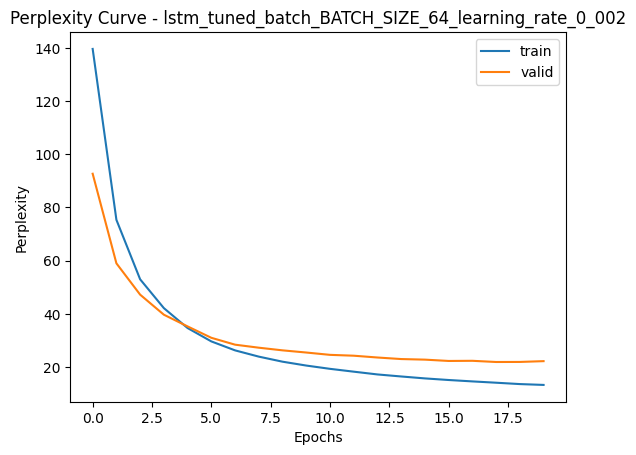

EPOCHS:20 filename:lstm_tuned_batch_BATCH_SIZE_64_learning_rate_0_003
-----------------------------------
Epoch 1
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 4.9178. Validation Loss: 4.5484. 
Training Perplexity: 136.7002. Validation Perplexity: 94.4851. 
-----------------------------------
Epoch 2
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 4.3241. Validation Loss: 4.1023. 
Training Perplexity: 75.5005. Validation Perplexity: 60.4812. 
-----------------------------------
Epoch 3
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 3.9707. Validation Loss: 3.8525. 
Training Perplexity: 53.0236. Validation Perplexity: 47.1090. 
-----------------------------------
Epoch 4
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 3.7382. Validation Loss: 3.6930. 
Training Perplexity: 42.0210. Validation Perplexity: 40.1646. 
-----------------------------------
Epoch 5
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 3.5555. Validation Loss: 3.5646. 
Training Perplexity: 35.0053. Validation Perplexity: 35.3249. 
-----------------------------------
Epoch 6
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 3.4080. Validation Loss: 3.4629. 
Training Perplexity: 30.2049. Validation Perplexity: 31.9088. 
-----------------------------------
Epoch 7
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 3.2747. Validation Loss: 3.3678. 
Training Perplexity: 26.4351. Validation Perplexity: 29.0149. 
-----------------------------------
Epoch 8
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 3.1613. Validation Loss: 3.3258. 
Training Perplexity: 23.6022. Validation Perplexity: 27.8211. 
-----------------------------------
Epoch 9
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 3.0665. Validation Loss: 3.2798. 
Training Perplexity: 21.4667. Validation Perplexity: 26.5704. 
-----------------------------------
Epoch 10
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 2.9847. Validation Loss: 3.2233. 
Training Perplexity: 19.7814. Validation Perplexity: 25.1109. 
-----------------------------------
Epoch 11
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 2.9150. Validation Loss: 3.1848. 
Training Perplexity: 18.4480. Validation Perplexity: 24.1613. 
-----------------------------------
Epoch 12
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 2.8491. Validation Loss: 3.1818. 
Training Perplexity: 17.2716. Validation Perplexity: 24.0898. 
-----------------------------------
Epoch 13
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 2.7942. Validation Loss: 3.1699. 
Training Perplexity: 16.3497. Validation Perplexity: 23.8052. 
-----------------------------------
Epoch 14
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 2.7473. Validation Loss: 3.1700. 
Training Perplexity: 15.6002. Validation Perplexity: 23.8075. 
-----------------------------------
Epoch 15
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 2.6994. Validation Loss: 3.1339. 
Training Perplexity: 14.8702. Validation Perplexity: 22.9625. 
-----------------------------------
Epoch 16
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 2.6622. Validation Loss: 3.1322. 
Training Perplexity: 14.3282. Validation Perplexity: 22.9248. 
-----------------------------------
Epoch 17
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 2.6240. Validation Loss: 3.1162. 
Training Perplexity: 13.7905. Validation Perplexity: 22.5610. 
-----------------------------------
Epoch 18
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 2.5886. Validation Loss: 3.1077. 
Training Perplexity: 13.3109. Validation Perplexity: 22.3706. 
-----------------------------------
Epoch 19
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 2.5558. Validation Loss: 3.1146. 
Training Perplexity: 12.8810. Validation Perplexity: 22.5255. 
-----------------------------------
Epoch 20
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 2.5285. Validation Loss: 3.1148. 
Training Perplexity: 12.5345. Validation Perplexity: 22.5280. 


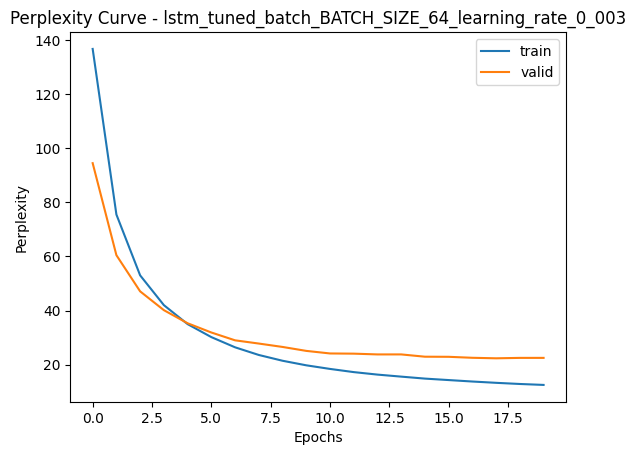

EPOCHS:20 filename:lstm_tuned_batch_BATCH_SIZE_64_decoder_emb_size_64
-----------------------------------
Epoch 1
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 5.1421. Validation Loss: 4.7494. 
Training Perplexity: 171.0812. Validation Perplexity: 115.5100. 
-----------------------------------
Epoch 2
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 4.6277. Validation Loss: 4.4543. 
Training Perplexity: 102.2758. Validation Perplexity: 85.9986. 
-----------------------------------
Epoch 3
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 4.3586. Validation Loss: 4.2201. 
Training Perplexity: 78.1442. Validation Perplexity: 68.0422. 
-----------------------------------
Epoch 4
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 4.1314. Validation Loss: 4.0126. 
Training Perplexity: 62.2644. Validation Perplexity: 55.2913. 
-----------------------------------
Epoch 5
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 3.9463. Validation Loss: 3.8744. 
Training Perplexity: 51.7446. Validation Perplexity: 48.1559. 
-----------------------------------
Epoch 6
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 3.8064. Validation Loss: 3.7657. 
Training Perplexity: 44.9896. Validation Perplexity: 43.1946. 
-----------------------------------
Epoch 7
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 3.6898. Validation Loss: 3.6737. 
Training Perplexity: 40.0371. Validation Perplexity: 39.3957. 
-----------------------------------
Epoch 8
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 3.5909. Validation Loss: 3.6264. 
Training Perplexity: 36.2650. Validation Perplexity: 37.5771. 
-----------------------------------
Epoch 9
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 3.5053. Validation Loss: 3.5730. 
Training Perplexity: 33.2913. Validation Perplexity: 35.6236. 
-----------------------------------
Epoch 10
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 3.4302. Validation Loss: 3.5255. 
Training Perplexity: 30.8816. Validation Perplexity: 33.9720. 
-----------------------------------
Epoch 11
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 3.3597. Validation Loss: 3.4903. 
Training Perplexity: 28.7802. Validation Perplexity: 32.7955. 
-----------------------------------
Epoch 12
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 3.2962. Validation Loss: 3.4348. 
Training Perplexity: 27.0090. Validation Perplexity: 31.0252. 
-----------------------------------
Epoch 13
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 3.2309. Validation Loss: 3.3989. 
Training Perplexity: 25.3017. Validation Perplexity: 29.9308. 
-----------------------------------
Epoch 14
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 3.1762. Validation Loss: 3.3612. 
Training Perplexity: 23.9546. Validation Perplexity: 28.8235. 
-----------------------------------
Epoch 15
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 3.1250. Validation Loss: 3.3133. 
Training Perplexity: 22.7604. Validation Perplexity: 27.4753. 
-----------------------------------
Epoch 16
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 3.0735. Validation Loss: 3.2822. 
Training Perplexity: 21.6181. Validation Perplexity: 26.6345. 
-----------------------------------
Epoch 17
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 3.0303. Validation Loss: 3.2901. 
Training Perplexity: 20.7038. Validation Perplexity: 26.8454. 
-----------------------------------
Epoch 18
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 2.9879. Validation Loss: 3.2786. 
Training Perplexity: 19.8440. Validation Perplexity: 26.5395. 
-----------------------------------
Epoch 19
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 2.9468. Validation Loss: 3.2355. 
Training Perplexity: 19.0457. Validation Perplexity: 25.4195. 
-----------------------------------
Epoch 20
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 2.9135. Validation Loss: 3.2160. 
Training Perplexity: 18.4207. Validation Perplexity: 24.9286. 


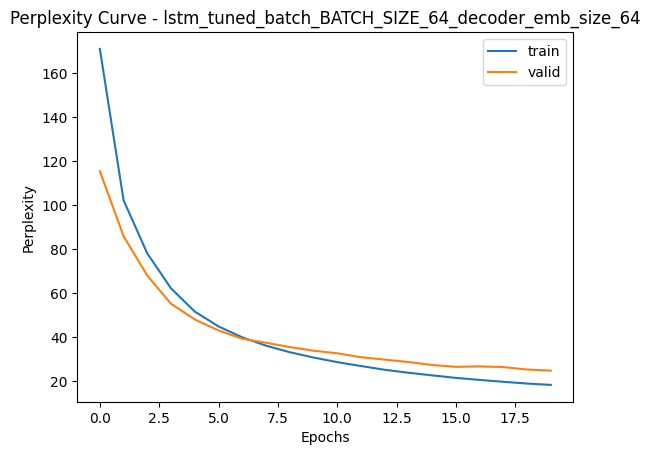

EPOCHS:20 filename:lstm_tuned_batch_BATCH_SIZE_64_encoder_emb_size_256
-----------------------------------
Epoch 1
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 5.1347. Validation Loss: 4.6468. 
Training Perplexity: 169.8052. Validation Perplexity: 104.2507. 
-----------------------------------
Epoch 2
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 4.4919. Validation Loss: 4.2934. 
Training Perplexity: 89.2895. Validation Perplexity: 73.2175. 
-----------------------------------
Epoch 3
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 4.2244. Validation Loss: 4.0905. 
Training Perplexity: 68.3317. Validation Perplexity: 59.7711. 
-----------------------------------
Epoch 4
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 3.9901. Validation Loss: 3.8630. 
Training Perplexity: 54.0613. Validation Perplexity: 47.6090. 
-----------------------------------
Epoch 5
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 3.7533. Validation Loss: 3.6745. 
Training Perplexity: 42.6607. Validation Perplexity: 39.4305. 
-----------------------------------
Epoch 6
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 3.5774. Validation Loss: 3.5467. 
Training Perplexity: 35.7816. Validation Perplexity: 34.6981. 
-----------------------------------
Epoch 7
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 3.4194. Validation Loss: 3.4117. 
Training Perplexity: 30.5516. Validation Perplexity: 30.3182. 
-----------------------------------
Epoch 8
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 3.2915. Validation Loss: 3.3502. 
Training Perplexity: 26.8819. Validation Perplexity: 28.5098. 
-----------------------------------
Epoch 9
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 3.1877. Validation Loss: 3.2587. 
Training Perplexity: 24.2331. Validation Perplexity: 26.0164. 
-----------------------------------
Epoch 10
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 3.0972. Validation Loss: 3.2076. 
Training Perplexity: 22.1351. Validation Perplexity: 24.7186. 
-----------------------------------
Epoch 11
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 3.0215. Validation Loss: 3.1594. 
Training Perplexity: 20.5218. Validation Perplexity: 23.5557. 
-----------------------------------
Epoch 12
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 2.9523. Validation Loss: 3.1249. 
Training Perplexity: 19.1499. Validation Perplexity: 22.7572. 
-----------------------------------
Epoch 13
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 2.8954. Validation Loss: 3.0936. 
Training Perplexity: 18.0911. Validation Perplexity: 22.0553. 
-----------------------------------
Epoch 14
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 2.8436. Validation Loss: 3.0661. 
Training Perplexity: 17.1783. Validation Perplexity: 21.4570. 
-----------------------------------
Epoch 15
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 2.7937. Validation Loss: 3.0560. 
Training Perplexity: 16.3411. Validation Perplexity: 21.2422. 
-----------------------------------
Epoch 16
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 2.7482. Validation Loss: 3.0333. 
Training Perplexity: 15.6139. Validation Perplexity: 20.7662. 
-----------------------------------
Epoch 17
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 2.7043. Validation Loss: 3.0194. 
Training Perplexity: 14.9440. Validation Perplexity: 20.4789. 
-----------------------------------
Epoch 18
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 2.6663. Validation Loss: 3.0046. 
Training Perplexity: 14.3871. Validation Perplexity: 20.1774. 
-----------------------------------
Epoch 19
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 2.6308. Validation Loss: 3.0105. 
Training Perplexity: 13.8855. Validation Perplexity: 20.2980. 
-----------------------------------
Epoch 20
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 2.6033. Validation Loss: 2.9908. 
Training Perplexity: 13.5076. Validation Perplexity: 19.9012. 


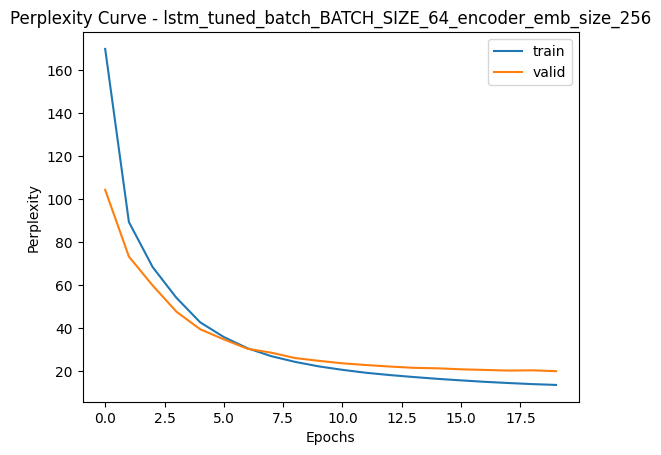

EPOCHS:20 filename:lstm_tuned_batch_BATCH_SIZE_64_decoder_dropout_0_3
-----------------------------------
Epoch 1
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 5.1476. Validation Loss: 4.6867. 
Training Perplexity: 172.0166. Validation Perplexity: 108.4995. 
-----------------------------------
Epoch 2
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 4.5726. Validation Loss: 4.4115. 
Training Perplexity: 96.7923. Validation Perplexity: 82.3890. 
-----------------------------------
Epoch 3
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 4.3319. Validation Loss: 4.2020. 
Training Perplexity: 76.0859. Validation Perplexity: 66.8195. 
-----------------------------------
Epoch 4
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 4.1590. Validation Loss: 4.0685. 
Training Perplexity: 64.0057. Validation Perplexity: 58.4670. 
-----------------------------------
Epoch 5
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 4.0172. Validation Loss: 3.9417. 
Training Perplexity: 55.5481. Validation Perplexity: 51.5083. 
-----------------------------------
Epoch 6
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 3.8624. Validation Loss: 3.8064. 
Training Perplexity: 47.5808. Validation Perplexity: 44.9904. 
-----------------------------------
Epoch 7
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 3.7300. Validation Loss: 3.7129. 
Training Perplexity: 41.6806. Validation Perplexity: 40.9730. 
-----------------------------------
Epoch 8
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 3.6261. Validation Loss: 3.6484. 
Training Perplexity: 37.5660. Validation Perplexity: 38.4143. 
-----------------------------------
Epoch 9
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 3.5382. Validation Loss: 3.5969. 
Training Perplexity: 34.4065. Validation Perplexity: 36.4867. 
-----------------------------------
Epoch 10
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 3.4644. Validation Loss: 3.5566. 
Training Perplexity: 31.9567. Validation Perplexity: 35.0447. 
-----------------------------------
Epoch 11
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 3.3964. Validation Loss: 3.5168. 
Training Perplexity: 29.8560. Validation Perplexity: 33.6779. 
-----------------------------------
Epoch 12
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 3.3368. Validation Loss: 3.4796. 
Training Perplexity: 28.1304. Validation Perplexity: 32.4469. 
-----------------------------------
Epoch 13
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 3.2788. Validation Loss: 3.4437. 
Training Perplexity: 26.5444. Validation Perplexity: 31.3015. 
-----------------------------------
Epoch 14
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 3.2270. Validation Loss: 3.4253. 
Training Perplexity: 25.2031. Validation Perplexity: 30.7317. 
-----------------------------------
Epoch 15
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 3.1775. Validation Loss: 3.3921. 
Training Perplexity: 23.9878. Validation Perplexity: 29.7284. 
-----------------------------------
Epoch 16
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 3.1257. Validation Loss: 3.3567. 
Training Perplexity: 22.7761. Validation Perplexity: 28.6952. 
-----------------------------------
Epoch 17
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 3.0811. Validation Loss: 3.3280. 
Training Perplexity: 21.7823. Validation Perplexity: 27.8811. 
-----------------------------------
Epoch 18
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 3.0381. Validation Loss: 3.3109. 
Training Perplexity: 20.8649. Validation Perplexity: 27.4091. 
-----------------------------------
Epoch 19
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 2.9984. Validation Loss: 3.2893. 
Training Perplexity: 20.0534. Validation Perplexity: 26.8239. 
-----------------------------------
Epoch 20
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 2.9602. Validation Loss: 3.2722. 
Training Perplexity: 19.3012. Validation Perplexity: 26.3693. 


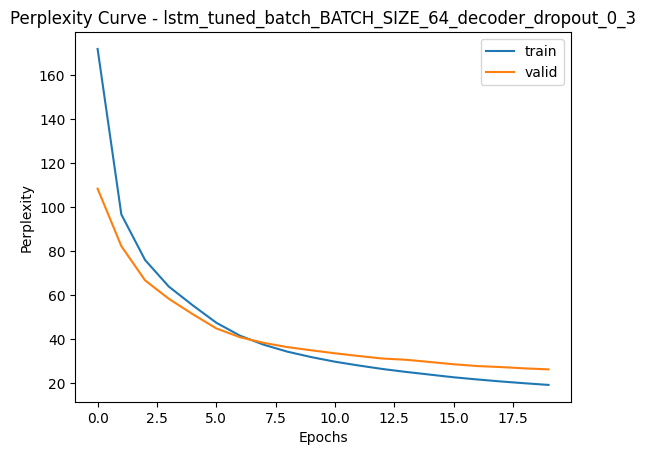

EPOCHS:20 filename:lstm_tuned_batch_BATCH_SIZE_64_decoder_dropout_0_1
-----------------------------------
Epoch 1
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 5.1150. Validation Loss: 4.6896. 
Training Perplexity: 166.5062. Validation Perplexity: 108.8134. 
-----------------------------------
Epoch 2
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 4.5586. Validation Loss: 4.3663. 
Training Perplexity: 95.4533. Validation Perplexity: 78.7495. 
-----------------------------------
Epoch 3
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 4.3012. Validation Loss: 4.1409. 
Training Perplexity: 73.7913. Validation Perplexity: 62.8584. 
-----------------------------------
Epoch 4
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 4.0671. Validation Loss: 3.9550. 
Training Perplexity: 58.3883. Validation Perplexity: 52.1957. 
-----------------------------------
Epoch 5
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 3.8989. Validation Loss: 3.8376. 
Training Perplexity: 49.3492. Validation Perplexity: 46.4162. 
-----------------------------------
Epoch 6
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 3.7685. Validation Loss: 3.7465. 
Training Perplexity: 43.3133. Validation Perplexity: 42.3715. 
-----------------------------------
Epoch 7
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 3.6549. Validation Loss: 3.6521. 
Training Perplexity: 38.6654. Validation Perplexity: 38.5573. 
-----------------------------------
Epoch 8
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 3.5492. Validation Loss: 3.5947. 
Training Perplexity: 34.7852. Validation Perplexity: 36.4061. 
-----------------------------------
Epoch 9
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 3.4523. Validation Loss: 3.5024. 
Training Perplexity: 31.5744. Validation Perplexity: 33.1961. 
-----------------------------------
Epoch 10
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 3.3695. Validation Loss: 3.4552. 
Training Perplexity: 29.0644. Validation Perplexity: 31.6639. 
-----------------------------------
Epoch 11
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 3.2956. Validation Loss: 3.4116. 
Training Perplexity: 26.9932. Validation Perplexity: 30.3147. 
-----------------------------------
Epoch 12
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 3.2316. Validation Loss: 3.3764. 
Training Perplexity: 25.3201. Validation Perplexity: 29.2666. 
-----------------------------------
Epoch 13
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 3.1740. Validation Loss: 3.3365. 
Training Perplexity: 23.9020. Validation Perplexity: 28.1206. 
-----------------------------------
Epoch 14
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 3.1221. Validation Loss: 3.3034. 
Training Perplexity: 22.6939. Validation Perplexity: 27.2053. 
-----------------------------------
Epoch 15
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 3.0746. Validation Loss: 3.2831. 
Training Perplexity: 21.6404. Validation Perplexity: 26.6595. 
-----------------------------------
Epoch 16
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 3.0295. Validation Loss: 3.2556. 
Training Perplexity: 20.6872. Validation Perplexity: 25.9355. 
-----------------------------------
Epoch 17
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 2.9903. Validation Loss: 3.2348. 
Training Perplexity: 19.8919. Validation Perplexity: 25.4024. 
-----------------------------------
Epoch 18
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 2.9542. Validation Loss: 3.1980. 
Training Perplexity: 19.1867. Validation Perplexity: 24.4847. 
-----------------------------------
Epoch 19
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 2.9143. Validation Loss: 3.2079. 
Training Perplexity: 18.4353. Validation Perplexity: 24.7269. 
-----------------------------------
Epoch 20
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 2.8826. Validation Loss: 3.1824. 
Training Perplexity: 17.8607. Validation Perplexity: 24.1037. 


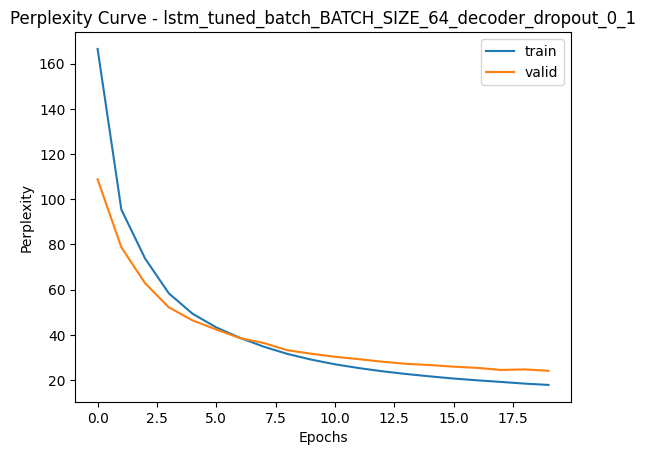

EPOCHS:20 filename:lstm_tuned_batch_BATCH_SIZE_64_encoder_dropout_0_3
-----------------------------------
Epoch 1
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 5.1334. Validation Loss: 4.6752. 
Training Perplexity: 169.5990. Validation Perplexity: 107.2589. 
-----------------------------------
Epoch 2
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 4.5673. Validation Loss: 4.3944. 
Training Perplexity: 96.2819. Validation Perplexity: 80.9928. 
-----------------------------------
Epoch 3
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 4.3345. Validation Loss: 4.2105. 
Training Perplexity: 76.2881. Validation Perplexity: 67.3916. 
-----------------------------------
Epoch 4
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 4.1587. Validation Loss: 4.0375. 
Training Perplexity: 63.9902. Validation Perplexity: 56.6818. 
-----------------------------------
Epoch 5
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 3.9817. Validation Loss: 3.8969. 
Training Perplexity: 53.6079. Validation Perplexity: 49.2497. 
-----------------------------------
Epoch 6
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 3.8441. Validation Loss: 3.7859. 
Training Perplexity: 46.7173. Validation Perplexity: 44.0732. 
-----------------------------------
Epoch 7
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 3.7347. Validation Loss: 3.7099. 
Training Perplexity: 41.8740. Validation Perplexity: 40.8502. 
-----------------------------------
Epoch 8
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 3.6449. Validation Loss: 3.6505. 
Training Perplexity: 38.2781. Validation Perplexity: 38.4955. 
-----------------------------------
Epoch 9
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 3.5621. Validation Loss: 3.5938. 
Training Perplexity: 35.2372. Validation Perplexity: 36.3725. 
-----------------------------------
Epoch 10
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 3.4867. Validation Loss: 3.5339. 
Training Perplexity: 32.6768. Validation Perplexity: 34.2577. 
-----------------------------------
Epoch 11
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 3.4140. Validation Loss: 3.4814. 
Training Perplexity: 30.3859. Validation Perplexity: 32.5040. 
-----------------------------------
Epoch 12
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 3.3489. Validation Loss: 3.4239. 
Training Perplexity: 28.4704. Validation Perplexity: 30.6882. 
-----------------------------------
Epoch 13
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 3.2894. Validation Loss: 3.3970. 
Training Perplexity: 26.8278. Validation Perplexity: 29.8732. 
-----------------------------------
Epoch 14
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 3.2333. Validation Loss: 3.3484. 
Training Perplexity: 25.3628. Validation Perplexity: 28.4563. 
-----------------------------------
Epoch 15
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 3.1813. Validation Loss: 3.3193. 
Training Perplexity: 24.0789. Validation Perplexity: 27.6407. 
-----------------------------------
Epoch 16
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 3.1359. Validation Loss: 3.3127. 
Training Perplexity: 23.0098. Validation Perplexity: 27.4598. 
-----------------------------------
Epoch 17
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 3.0926. Validation Loss: 3.2646. 
Training Perplexity: 22.0353. Validation Perplexity: 26.1691. 
-----------------------------------
Epoch 18
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 3.0542. Validation Loss: 3.2736. 
Training Perplexity: 21.2045. Validation Perplexity: 26.4052. 
-----------------------------------
Epoch 19
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 3.0166. Validation Loss: 3.2279. 
Training Perplexity: 20.4217. Validation Perplexity: 25.2270. 
-----------------------------------
Epoch 20
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 2.9838. Validation Loss: 3.2465. 
Training Perplexity: 19.7626. Validation Perplexity: 25.6998. 


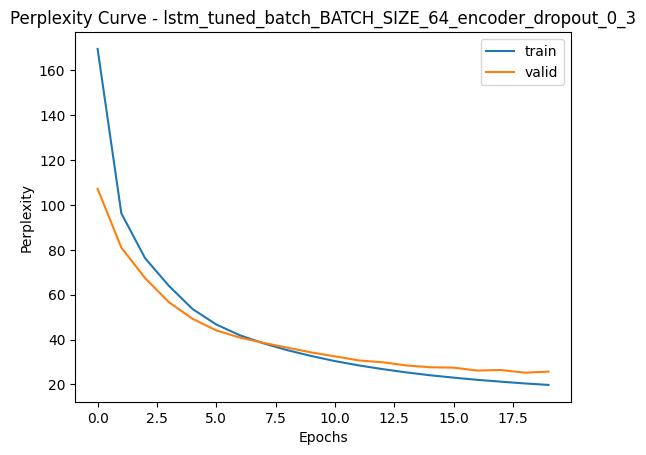

EPOCHS:20 filename:lstm_tuned_batch_BATCH_SIZE_64_encoder_dropout_0_1
-----------------------------------
Epoch 1
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 5.1447. Validation Loss: 4.6781. 
Training Perplexity: 171.5270. Validation Perplexity: 107.5702. 
-----------------------------------
Epoch 2
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 4.5520. Validation Loss: 4.3656. 
Training Perplexity: 94.8179. Validation Perplexity: 78.6982. 
-----------------------------------
Epoch 3
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 4.2976. Validation Loss: 4.1775. 
Training Perplexity: 73.5233. Validation Perplexity: 65.2005. 
-----------------------------------
Epoch 4
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 4.1232. Validation Loss: 4.0288. 
Training Perplexity: 61.7543. Validation Perplexity: 56.1913. 
-----------------------------------
Epoch 5
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 3.9470. Validation Loss: 3.8750. 
Training Perplexity: 51.7798. Validation Perplexity: 48.1817. 
-----------------------------------
Epoch 6
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 3.7829. Validation Loss: 3.7652. 
Training Perplexity: 43.9434. Validation Perplexity: 43.1711. 
-----------------------------------
Epoch 7
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 3.6571. Validation Loss: 3.6793. 
Training Perplexity: 38.7497. Validation Perplexity: 39.6199. 
-----------------------------------
Epoch 8
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 3.5531. Validation Loss: 3.6168. 
Training Perplexity: 34.9210. Validation Perplexity: 37.2201. 
-----------------------------------
Epoch 9
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 3.4619. Validation Loss: 3.5653. 
Training Perplexity: 31.8762. Validation Perplexity: 35.3509. 
-----------------------------------
Epoch 10
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 3.3800. Validation Loss: 3.5115. 
Training Perplexity: 29.3700. Validation Perplexity: 33.4974. 
-----------------------------------
Epoch 11
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 3.3075. Validation Loss: 3.4684. 
Training Perplexity: 27.3180. Validation Perplexity: 32.0861. 
-----------------------------------
Epoch 12
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 3.2384. Validation Loss: 3.4249. 
Training Perplexity: 25.4918. Validation Perplexity: 30.7209. 
-----------------------------------
Epoch 13
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 3.1740. Validation Loss: 3.3904. 
Training Perplexity: 23.9019. Validation Perplexity: 29.6766. 
-----------------------------------
Epoch 14
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 3.1140. Validation Loss: 3.3710. 
Training Perplexity: 22.5110. Validation Perplexity: 29.1081. 
-----------------------------------
Epoch 15
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 3.0581. Validation Loss: 3.3342. 
Training Perplexity: 21.2879. Validation Perplexity: 28.0552. 
-----------------------------------
Epoch 16
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 3.0071. Validation Loss: 3.3096. 
Training Perplexity: 20.2285. Validation Perplexity: 27.3728. 
-----------------------------------
Epoch 17
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 2.9591. Validation Loss: 3.2974. 
Training Perplexity: 19.2814. Validation Perplexity: 27.0425. 
-----------------------------------
Epoch 18
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 2.9174. Validation Loss: 3.2624. 
Training Perplexity: 18.4924. Validation Perplexity: 26.1123. 
-----------------------------------
Epoch 19
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 2.8744. Validation Loss: 3.2552. 
Training Perplexity: 17.7150. Validation Perplexity: 25.9251. 
-----------------------------------
Epoch 20
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 2.8359. Validation Loss: 3.2414. 
Training Perplexity: 17.0454. Validation Perplexity: 25.5691. 


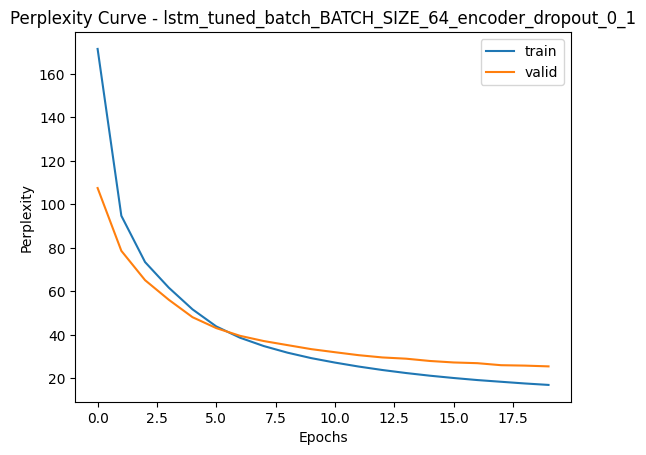

EPOCHS:20 filename:lstm_tuned_batch_BATCH_SIZE_64_decoder_dropout_0_3_learning_rate_0_002
-----------------------------------
Epoch 1
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 4.9686. Validation Loss: 4.5881. 
Training Perplexity: 143.8219. Validation Perplexity: 98.3123. 
-----------------------------------
Epoch 2
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 4.4012. Validation Loss: 4.1687. 
Training Perplexity: 81.5513. Validation Perplexity: 64.6338. 
-----------------------------------
Epoch 3
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 4.0425. Validation Loss: 3.9174. 
Training Perplexity: 56.9696. Validation Perplexity: 50.2692. 
-----------------------------------
Epoch 4
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 3.8130. Validation Loss: 3.7475. 
Training Perplexity: 45.2878. Validation Perplexity: 42.4143. 
-----------------------------------
Epoch 5
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 3.6397. Validation Loss: 3.6338. 
Training Perplexity: 38.0821. Validation Perplexity: 37.8567. 
-----------------------------------
Epoch 6
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 3.5009. Validation Loss: 3.5369. 
Training Perplexity: 33.1448. Validation Perplexity: 34.3596. 
-----------------------------------
Epoch 7
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 3.3833. Validation Loss: 3.4622. 
Training Perplexity: 29.4673. Validation Perplexity: 31.8884. 
-----------------------------------
Epoch 8
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 3.2743. Validation Loss: 3.3879. 
Training Perplexity: 26.4247. Validation Perplexity: 29.6031. 
-----------------------------------
Epoch 9
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 3.1814. Validation Loss: 3.3525. 
Training Perplexity: 24.0801. Validation Perplexity: 28.5749. 
-----------------------------------
Epoch 10
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 3.0968. Validation Loss: 3.2920. 
Training Perplexity: 22.1260. Validation Perplexity: 26.8970. 
-----------------------------------
Epoch 11
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 3.0276. Validation Loss: 3.2713. 
Training Perplexity: 20.6482. Validation Perplexity: 26.3455. 
-----------------------------------
Epoch 12
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 2.9653. Validation Loss: 3.2476. 
Training Perplexity: 19.4012. Validation Perplexity: 25.7278. 
-----------------------------------
Epoch 13
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 2.9089. Validation Loss: 3.2387. 
Training Perplexity: 18.3361. Validation Perplexity: 25.4994. 
-----------------------------------
Epoch 14
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 2.8567. Validation Loss: 3.1828. 
Training Perplexity: 17.4033. Validation Perplexity: 24.1151. 
-----------------------------------
Epoch 15
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 2.8088. Validation Loss: 3.1747. 
Training Perplexity: 16.5906. Validation Perplexity: 23.9195. 
-----------------------------------
Epoch 16
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 2.7717. Validation Loss: 3.1576. 
Training Perplexity: 15.9861. Validation Perplexity: 23.5140. 
-----------------------------------
Epoch 17
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 2.7348. Validation Loss: 3.1370. 
Training Perplexity: 15.4064. Validation Perplexity: 23.0350. 
-----------------------------------
Epoch 18
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 2.6977. Validation Loss: 3.1200. 
Training Perplexity: 14.8456. Validation Perplexity: 22.6454. 
-----------------------------------
Epoch 19
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 2.6633. Validation Loss: 3.1166. 
Training Perplexity: 14.3429. Validation Perplexity: 22.5697. 
-----------------------------------
Epoch 20
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 2.6312. Validation Loss: 3.1126. 
Training Perplexity: 13.8902. Validation Perplexity: 22.4786. 


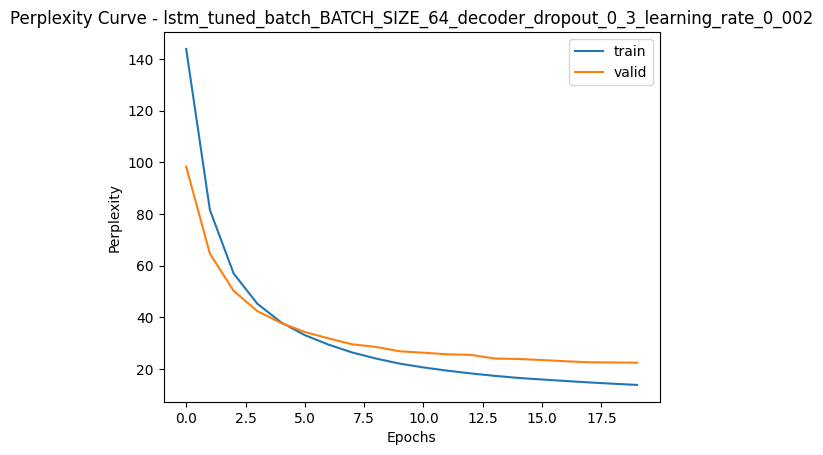

EPOCHS:40 filename:lstm_tuned_batch_BATCH_SIZE_64_decoder_dropout_0_3_learning_rate_0_002_EPOCHS_40
-----------------------------------
Epoch 1
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 4.9686. Validation Loss: 4.5881. 
Training Perplexity: 143.8219. Validation Perplexity: 98.3123. 
-----------------------------------
Epoch 2
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 4.4012. Validation Loss: 4.1687. 
Training Perplexity: 81.5513. Validation Perplexity: 64.6338. 
-----------------------------------
Epoch 3
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 4.0425. Validation Loss: 3.9174. 
Training Perplexity: 56.9696. Validation Perplexity: 50.2692. 
-----------------------------------
Epoch 4
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 3.8130. Validation Loss: 3.7475. 
Training Perplexity: 45.2878. Validation Perplexity: 42.4143. 
-----------------------------------
Epoch 5
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 3.6397. Validation Loss: 3.6338. 
Training Perplexity: 38.0821. Validation Perplexity: 37.8567. 
-----------------------------------
Epoch 6
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 3.5009. Validation Loss: 3.5369. 
Training Perplexity: 33.1448. Validation Perplexity: 34.3596. 
-----------------------------------
Epoch 7
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 3.3833. Validation Loss: 3.4622. 
Training Perplexity: 29.4673. Validation Perplexity: 31.8884. 
-----------------------------------
Epoch 8
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 3.2743. Validation Loss: 3.3879. 
Training Perplexity: 26.4247. Validation Perplexity: 29.6031. 
-----------------------------------
Epoch 9
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 3.1814. Validation Loss: 3.3525. 
Training Perplexity: 24.0801. Validation Perplexity: 28.5749. 
-----------------------------------
Epoch 10
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 3.0968. Validation Loss: 3.2920. 
Training Perplexity: 22.1260. Validation Perplexity: 26.8970. 
-----------------------------------
Epoch 11
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 3.0276. Validation Loss: 3.2713. 
Training Perplexity: 20.6482. Validation Perplexity: 26.3455. 
-----------------------------------
Epoch 12
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 2.9653. Validation Loss: 3.2476. 
Training Perplexity: 19.4012. Validation Perplexity: 25.7278. 
-----------------------------------
Epoch 13
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 2.9089. Validation Loss: 3.2387. 
Training Perplexity: 18.3361. Validation Perplexity: 25.4994. 
-----------------------------------
Epoch 14
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 2.8567. Validation Loss: 3.1828. 
Training Perplexity: 17.4033. Validation Perplexity: 24.1151. 
-----------------------------------
Epoch 15
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 2.8088. Validation Loss: 3.1747. 
Training Perplexity: 16.5906. Validation Perplexity: 23.9195. 
-----------------------------------
Epoch 16
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 2.7717. Validation Loss: 3.1576. 
Training Perplexity: 15.9861. Validation Perplexity: 23.5140. 
-----------------------------------
Epoch 17
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 2.7348. Validation Loss: 3.1370. 
Training Perplexity: 15.4064. Validation Perplexity: 23.0350. 
-----------------------------------
Epoch 18
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 2.6977. Validation Loss: 3.1200. 
Training Perplexity: 14.8456. Validation Perplexity: 22.6454. 
-----------------------------------
Epoch 19
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 2.6633. Validation Loss: 3.1166. 
Training Perplexity: 14.3429. Validation Perplexity: 22.5697. 
-----------------------------------
Epoch 20
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 2.6312. Validation Loss: 3.1126. 
Training Perplexity: 13.8902. Validation Perplexity: 22.4786. 
-----------------------------------
Epoch 21
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 2.6023. Validation Loss: 3.1120. 
Training Perplexity: 13.4949. Validation Perplexity: 22.4664. 
-----------------------------------
Epoch 22
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 2.5726. Validation Loss: 3.1068. 
Training Perplexity: 13.1005. Validation Perplexity: 22.3504. 
-----------------------------------
Epoch 23
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 2.5451. Validation Loss: 3.1100. 
Training Perplexity: 12.7449. Validation Perplexity: 22.4217. 
-----------------------------------
Epoch 24
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 2.5225. Validation Loss: 3.0849. 
Training Perplexity: 12.4593. Validation Perplexity: 21.8642. 
-----------------------------------
Epoch 25
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 2.5005. Validation Loss: 3.0745. 
Training Perplexity: 12.1881. Validation Perplexity: 21.6383. 
-----------------------------------
Epoch 26
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 2.4761. Validation Loss: 3.0632. 
Training Perplexity: 11.8945. Validation Perplexity: 21.3968. 
-----------------------------------
Epoch 27
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 2.4557. Validation Loss: 3.0775. 
Training Perplexity: 11.6547. Validation Perplexity: 21.7051. 
-----------------------------------
Epoch 28
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 2.4343. Validation Loss: 3.0749. 
Training Perplexity: 11.4082. Validation Perplexity: 21.6486. 
-----------------------------------
Epoch 29
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 2.4148. Validation Loss: 3.0624. 
Training Perplexity: 11.1876. Validation Perplexity: 21.3786. 
-----------------------------------
Epoch 30
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 2.3949. Validation Loss: 3.0763. 
Training Perplexity: 10.9668. Validation Perplexity: 21.6782. 
-----------------------------------
Epoch 31
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 2.3739. Validation Loss: 3.0763. 
Training Perplexity: 10.7391. Validation Perplexity: 21.6771. 
-----------------------------------
Epoch 32
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 2.3606. Validation Loss: 3.0845. 
Training Perplexity: 10.5975. Validation Perplexity: 21.8568. 
-----------------------------------
Epoch 33
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 2.3412. Validation Loss: 3.0552. 
Training Perplexity: 10.3934. Validation Perplexity: 21.2260. 
-----------------------------------
Epoch 34
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 2.3246. Validation Loss: 3.0613. 
Training Perplexity: 10.2230. Validation Perplexity: 21.3550. 
-----------------------------------
Epoch 35
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 2.3090. Validation Loss: 3.0774. 
Training Perplexity: 10.0643. Validation Perplexity: 21.7027. 
-----------------------------------
Epoch 36
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 2.2964. Validation Loss: 3.0515. 
Training Perplexity: 9.9382. Validation Perplexity: 21.1470. 
-----------------------------------
Epoch 37
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 2.2790. Validation Loss: 3.0542. 
Training Perplexity: 9.7666. Validation Perplexity: 21.2047. 
-----------------------------------
Epoch 38
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 2.2638. Validation Loss: 3.0570. 
Training Perplexity: 9.6197. Validation Perplexity: 21.2644. 
-----------------------------------
Epoch 39
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 2.2505. Validation Loss: 3.0600. 
Training Perplexity: 9.4929. Validation Perplexity: 21.3286. 
-----------------------------------
Epoch 40
-----------------------------------


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Training Loss: 2.2388. Validation Loss: 3.0666. 
Training Perplexity: 9.3824. Validation Perplexity: 21.4693. 


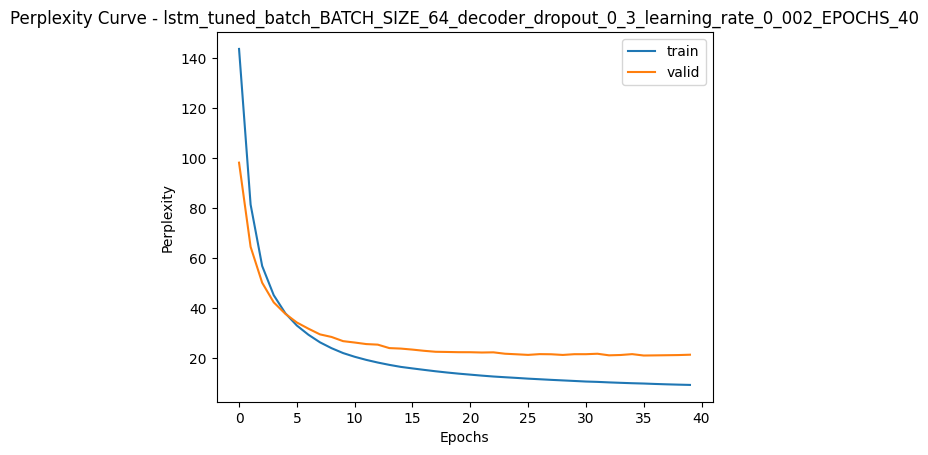

In [ ]:
# run_training(encoder_dropout=0.1)
# run_training(encoder_dropout=0.4)
# run_training(decoder_dropout=0.1)
# run_training(decoder_dropout=0.4)
# run_training(encoder_emb_size=64)
# run_training(encoder_emb_size=256)
# run_training(decoder_emb_size=64)
# run_training(decoder_emb_size=256)
# NEED TO FIX
# run_training(decoder_hidden_size=64)
# run_training(decoder_hidden_size=256)
# run_training(encoder_emb_size=256,decoder_emb_size=64,decoder_dropout=0.3)
# run_training(EPOCHS=80,BATCH_SIZE=256,learning_rate=0.003)
# run_training(BATCH_SIZE=64,encoder_emb_size=256,decoder_emb_size=64,decoder_dropout=0.3)
# run_training(BATCH_SIZE=64,learning_rate=0.002)
# run_training(BATCH_SIZE=64,learning_rate=0.003)
# run_training(BATCH_SIZE=64,decoder_emb_size=64)
# run_training(BATCH_SIZE=64,encoder_emb_size=256)
# run_training(BATCH_SIZE=64,decoder_dropout=0.3)
# run_training(BATCH_SIZE=64,decoder_dropout=0.1)
# run_training(BATCH_SIZE=64,encoder_dropout=0.3)
# run_training(BATCH_SIZE=64,encoder_dropout=0.1)
# run_training(BATCH_SIZE=64,decoder_dropout=0.3,learning_rate=0.002)
# run_training(BATCH_SIZE=64,decoder_dropout=0.3,learning_rate=0.002,EPOCHS=40)
run_training(BATCH_SIZE=64,decoder_dropout=0.3,learning_rate=0.002,encoder_emb_size=256, EPOCHS=100)
run_training(BATCH_SIZE=64,encoder_dropout=0.3,learning_rate=0.002,encoder_emb_size=256, EPOCHS=100)
run_training(BATCH_SIZE=64,encoder_dropout=0.3,decoder_dropout=0.3,learning_rate=0.002,encoder_emb_size=256, EPOCHS=100)
run_training(BATCH_SIZE=64,decoder_dropout=0.3,learning_rate=0.002,encoder_emb_size=256, decoder_emb_size=256, EPOCHS=100)
run_training(BATCH_SIZE=64,decoder_dropout=0.3,learning_rate=0.002,encoder_emb_size=256, decoder_emb_size=64, EPOCHS=100)
run_training(BATCH_SIZE=64,decoder_dropout=0.3,learning_rate=0.001,encoder_emb_size=256, decoder_emb_size=256, EPOCHS=100)
run_training(BATCH_SIZE=64,decoder_dropout=0.3,learning_rate=0.001,encoder_emb_size=256, decoder_emb_size=64, EPOCHS=100)

In [ ]:
# from google.colab import runtime
# runtime.unassign()
print("FINISHED")

FINISHED
